## colab 연결 및 unzip



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%cd /content/drive/MyDrive/hand_class/

#!unzip -qq "/content/drive/MyDrive/hand_class/user_data.zip"

/content/drive/MyDrive/hand_class


라벨 불러오기


In [ ]:
import pandas as pd
label_df = pd.read_csv('/content/drive/MyDrive/hand_class/train.csv')
label_df.head()

,file_name,label
0,001.png,10-2
1,002.png,10-1
2,003.png,3
3,004.png,8
4,005.png,9


In [ ]:
label_df['label'][label_df['label'] == '10-1'] = 10 ## label : 10-1 -> 10
label_df['label'][label_df['label'] == '10-2'] = 0 ## Label : 10-2 -> 0
label_df['label'] = label_df['label'].apply(lambda x : int(x)) ## Dtype : object -> int

## 이미지 불러오기 (baseline 코드)

In [ ]:
import os
import warnings
warnings.filterwarnings(action='ignore')

os.environ["CUDA_VISIBLE_DEVICES"]="0" # GPU 할당

In [ ]:
from glob import glob
import numpy as np
import PIL
from PIL import Image

def get_train_data(path):
    training_images = []
    training_labels = []
    
    flist = sorted(glob(path + '/*.png'))

    for filename in flist:
        an_img = PIL.Image.open(filename) #read img
        img_array = np.array(an_img) #img to array
        training_images.append(img_array) #append array to training_images

    #label_df = pd.read_csv(data_dir+'/train.csv')
    training_labels.extend(label_df['label'])

    training_images = np.array(training_images)
    training_labels = np.array(training_labels)
                
    return training_images, training_labels

def get_test_data(path):
    test_images = []
    
    flist = sorted(glob(path + '/*.png'))

    for filename in flist:
        an_img = PIL.Image.open(filename) #read img
        img_array = np.array(an_img) #img to array
        test_images.append(img_array) #append array to training_images
        
    test_images = np.array(test_images)
    
    return test_images

In [ ]:
training_images, training_labels = get_train_data('/content/drive/MyDrive/hand_class/train')
test_images = get_test_data('/content/drive/MyDrive/hand_class/test')

In [ ]:
print(training_images.shape)
print(training_labels.shape)
print(test_images.shape)

(858, 224, 224, 3)
(858,)
(215, 224, 224, 3)


0,10,3,8,9,9,8,0,5,5,9,2,4,10,9,2,0,7,4,2,

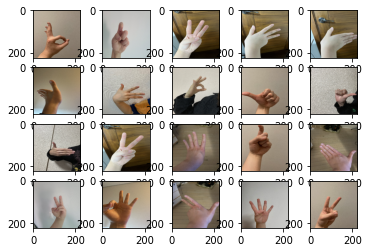

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(training_images[i])
    print(training_labels[i], end=",")
plt.show()

# 데이터 전처리

# 모델 생성하기

resnet50

In [ ]:
def identity_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters*4, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [ ]:
def convolutional_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters*4, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X_shortcut = tf.keras.layers.Conv2D(filters*4, (1,1), padding='SAME')(X_shortcut) #use 1x1 conv to make shape same
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
     
    return X

### Resnet 50

In [ ]:
def ResNet50(input_shape = (224, 224, 3), classes = 11):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input

    X = tf.keras.layers.Conv2D(64, (7,7), padding='SAME', strides = (2,2))(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)

    X = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='SAME')(X)

    
    X = convolutional_block(X, 64, (3,3)) #conv
    X = identity_block(X, 64, (3,3))
    X = identity_block(X, 64, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 128, (3,3)) #64->128, use conv block
    X = identity_block(X, 128, (3,3))
    X = identity_block(X, 128, (3,3))
    X = identity_block(X, 128, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 256, (3,3)) #128->256, use conv block
    X = identity_block(X, 256, (3,3))
    X = identity_block(X, 256, (3,3))
    X = identity_block(X, 256, (3,3))
    X = identity_block(X, 256, (3,3))
    X = identity_block(X, 256, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 512, (3,3)) #256->512, use conv block
    X = identity_block(X, 512, (3,3))
    X = identity_block(X, 512, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    X = tf.keras.layers.Dense(11, activation = 'softmax')(X) # ouput layer (11 class)

    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "ResNet50")
    
    return model

In [ ]:
import tensorflow as tf

tf.random.set_seed(42)

model = ResNet50()

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                          

## data augmentation을 통한 데이터 생성

vertical_flip은 사용하지 않습니다.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    brightness_range = [0.6, 1.0],
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

# 모델 학습하기

## ResNet50 with TTA

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True) #총 10번의 fold 진행
n = 0 #x번째 fold인지 기록

#cnn_pred = [] #모델의 예측값 모두 저장

X_test = test_images
X_test_ori = np.array(X_test)
X_test = X_test / 255.0

for train_index, valid_index in skf.split(training_images, training_labels):
    n += 1
    if n < 5:
      print(n)
      continue
    X_train, X_valid = training_images[train_index], training_images[valid_index]
    y_train, y_valid = training_labels[train_index], training_labels[valid_index]

    ### Data Augmentation for train data ###
    X_train_ori = np.array(X_train)
    
    y_train_mix = np.array(y_train)

    for i in range(9):
      X_train_mix = image_generator.flow(X_train_ori, np.zeros(X_train_ori.shape[0]), batch_size=X_train_ori.shape[0], shuffle=False, seed = 42^n^i).next()[0]
      X_train = np.append(X_train, X_train_mix, axis = 0)
      y_train = np.append(y_train, y_train_mix, axis = 0)
    
    ### Mix Data Again ####
    X_train, y_train = shuffle(X_train, y_train, random_state=42)

    ### preprocess Data ###
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0
    
    y_train = tf.one_hot(y_train, 11) #one-hot 기법 적용
    y_train = np.array(y_train)
    y_train = y_train.reshape(-1,11) #one-hot 기법을 적용했다면, shape을 바꿔줍니다.
    
    y_valid = tf.one_hot(y_valid, 11)
    y_valid = np.array(y_valid)
    y_valid = y_valid.reshape(-1,11)

    ### Create Model ###
    model = ResNet50()
    
    ### Compile Model ###
    model.compile(optimizer='adam', # 무난한 adam 사용
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    ### Create callbacks ###
    filename = 'Resnet-checkpoint.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filename,             # file명을 지정합니다
                                                    monitor='val_accuracy',   # val_accuracy 값이 개선되었을때 호출됩니다
                                                    verbose=0,            # 로그를 출력합니다 0일경우 출력 X
                                                    save_best_only=True,  # 가장 best 값만 저장합니다
                                                    mode='auto'           # auto는 알아서 best를 찾습니다. min/max (loss->min, accuracy->max)
                                                   )
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',  # 모니터 기준 설정 (val loss) 
                                  patience=12,         # 12 Epoch동안 개선되지 않는다면 종료
                                 )
    reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', # val_accuracy 값이 개선되었을때 호출됩니다
        factor=0.5, # learning rate이 0.5배 줄어듬
        patience=6, # 6 Epoch동안 개선되지 않는다면 호출
    )
    
    ### fit model ###
    data = model.fit(X_train, 
                     y_train, 
                     validation_data=(X_valid, y_valid), 
                     epochs=40, 
                     batch_size=32, # batch size가 32일때 가장 좋은 성능을 보임
                     callbacks=[reduceLR, earlystopping, checkpoint],
                     verbose=1 # 0으로 설정시 로그 출력을 없앰, 어짜피 아래 print에서 한번에 best_accuracy만 출력할것이기 때문이다.
                    )
    
    idx = data.history['val_accuracy'].index(max(data.history['val_accuracy']))
    
    print("fold %d / val_accuracy : %0.4f / val_loss : %0.4f" %(n,
                                                                data.history['val_accuracy'][idx], 
                                                                data.history['val_loss'][idx]))
    
    ### predict model ###
    model = tf.keras.models.load_model('./Resnet-checkpoint.h5') # best accuracy를 기록한 모델을 불러옴

    pred_proba = model.predict(X_test)

    #TTA 적용
    for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
        X_test_aug = image_generator.flow(X_test_ori, np.zeros(215), batch_size=215, shuffle=False, seed = 42^i).next()[0]
        X_test_aug = X_test_aug / 255.0
        pred_proba_aug = model.predict(X_test_aug)
        pred_proba = np.add(pred_proba, pred_proba_aug)
        
    cnn_pred.append(pred_proba) # 예측값을 cnn_pred 리스트에 저장

In [ ]:
cnn_pred.shape

(5, 215, 11)

In [ ]:
print(y_train.shape, y_valid.shape, X_train.shape, X_valid.shape)

(6870, 11) (171, 11) (6870, 224, 224, 3) (171, 224, 224, 3)


# 제출하기

In [ ]:
pred_proba = cnn_pred[0]

pred_proba = np.array(pred_proba)
print(pred_proba[0])

for x in range(1, 5):
    pred_proba += cnn_pred[x]
    print(cnn_pred[x][0])

pred_class = []

for i in pred_proba:
    pred = np.argmax(i)
    pred_class.append(pred)

[2.89949767e-05 9.96273518e+00 7.40705465e-04 3.33069562e-04
 3.10387965e-02 3.37381806e-07 1.03610149e-03 1.79233866e-05
 1.21094185e-04 4.23497549e-04 3.52438074e-03]
[1.9974008e-04 9.9755220e+00 5.9974187e-05 3.0982046e-04 1.8248965e-04
 3.4134999e-05 2.3300529e-02 3.7098423e-05 1.3064554e-04 1.4522263e-05
 2.0930429e-04]
[4.2912364e-04 9.9994926e+00 1.3611214e-05 5.9442340e-07 2.1339511e-07
 2.4958271e-09 2.6969428e-05 1.8950798e-08 1.9251995e-06 2.8170130e-06
 3.1529034e-05]
[3.2234425e-04 9.8748045e+00 7.8490959e-04 4.5917481e-03 4.9363296e-02
 3.2550684e-05 2.5000847e-03 1.4290503e-04 1.7150109e-04 2.4909245e-05
 6.7261398e-02]
[8.4430640e-06 9.9988871e+00 8.1694794e-05 2.3629977e-05 8.9138222e-04
 3.0293447e-07 1.0110119e-04 1.7094622e-07 4.4742674e-08 1.0960660e-07
 6.6979132e-06]


In [ ]:
final_pred_class = []

for x in pred_class:
  if x == 10:
    final_pred_class.append("10-1")
  elif x == 0:
    final_pred_class.append("10-2")
  else:
    final_pred_class.append(x)

In [ ]:
sample_submission = pd.read_csv("/content/drive/MyDrive/hand_class/sample_submission.csv")

sample_submission['label'] = final_pred_class
sample_submission.to_csv("/content/drive/MyDrive/hand_class/submit_2.csv",index=False)

In [ ]:
sample_submission.head()

,file_name,label
0,001.png,1
1,002.png,2
2,003.png,1
3,004.png,6
4,005.png,8
